In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [41]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")

In [24]:
vessels_df = pd.read_csv('data/vessels.csv', sep = '|')

In [25]:
ports_df = pd.read_csv('data/ports.csv', sep = '|')

In [42]:
test_df = pd.read_csv('data/ais_test.csv', sep = ',')

In [6]:
import pandas as pd
import pandas.api.types
from geopy.distance import geodesic
import numpy as np

class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Calculates the weighted distance between the actual and predicted latitude/longitude points.
    
    The function computes the geodesic distance between the actual coordinates (`latitude`, `longitude`) 
    and the predicted coordinates (`latitude_predicted`, `longitude_predicted`) in meters. 
    This distance is then scaled by the provided `scaling_factor` to obtain the weighted distance.
    '''

    # TODO: You likely want to delete the row ID column, which Kaggle's system uses to align
    # the solution and submission before passing these dataframes to score().
    #del solution[row_id_column_name]
    #del submission[row_id_column_name]

    # TODO: adapt or remove this check depending on what data types make sense for your metric
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
                    
    # TODO: add additional checks appropriate for your metric. Common things to check include:
    # Non-negative inputs, the wrong number of columns in the submission, values that should be restricted to a range, etc.
    # The more errors you tag as participant visible, the easier it will be for participants to debug their submissions.

    for col in ["ID", "longitude_predicted", "latitude_predicted"]: 
        if col not in submission.columns: 
            raise ParticipantVisibleError(f'Submission is missing column {col}')

    # TODO: calculate your metric here. For the template, we'll just calculate a simple mean absolute error over all non-id columns.
    # By default, the metric doesn't have information about what columns to expect. You probably want to add the names of other
    # columns as arguments to score, like row_id_column_name, if you won't be processing all columns the same way.
    
    # Merging the predictions to the ground truth

    try:
        solution_submission = solution.merge(submission[[row_id_column_name, 'longitude_predicted', 'latitude_predicted']], on=row_id_column_name, how='left')
        solution_submission['weighted_distance'] = solution_submission.apply(calculate_distance, axis=1)
    
        weighted_distance = solution_submission['weighted_distance'].mean() / 1000.0

        return weighted_distance
    
    except:
        raise ParticipantVisibleError(f'Evaluation metric raised an unexpected error')
    

def calculate_distance(row):
    """Calculates the weighted distance between the actual and predicted lat/long points."""
    if pd.isna(row['latitude']) or pd.isna(row['latitude_predicted']):
        return np.nan
    # Calculate the geodesic distance in meters
    distance = geodesic((row['latitude'], row['longitude']), 
                        (row['latitude_predicted'], row['longitude_predicted'])).meters
    # Weight the distance by the scaling factor
    weighted_distance = distance * row['scaling_factor']
    return weighted_distance

## Preprocessing

In [50]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")
test_df = pd.read_csv('data/ais_test.csv', sep = ',')

train_df = train_df.sort_values(by = 'vesselId')
test_df = test_df.sort_values(by = 'vesselId')

train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

timestamps = train_df[['time', 'vesselId']]

train_df['day_of_week'] = train_df['time'].dt.dayofweek
train_df['hour'] = train_df['time'].dt.hour
train_df['month'] = train_df['time'].dt.month

test_df['day_of_week'] = test_df['time'].dt.dayofweek
test_df['hour'] = test_df['time'].dt.hour
test_df['month'] = test_df['time'].dt.month

le_vesselid = LabelEncoder()
le_vesselid.fit(train_df['vesselId'])
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes
train_df['portId'] = pd.Categorical(train_df['portId']).codes   

train_df['latitude_1'] = train_df['latitude'].shift(-1)
train_df['latitude_2'] = train_df['latitude'].shift(-2)
train_df['latitude_3'] = train_df['latitude'].shift(-3)
train_df['latitude_4'] = train_df['latitude'].shift(-4)
train_df['latitude_5'] = train_df['latitude'].shift(-5)

train_df['longitude_1'] = train_df['longitude'].shift(-1)
train_df['longitude_2'] = train_df['longitude'].shift(-2)
train_df['longitude_3'] = train_df['longitude'].shift(-3)
train_df['longitude_4'] = train_df['longitude'].shift(-4)
train_df['longitude_5'] = train_df['longitude'].shift(-5)

train_df = train_df.dropna()
train_df = train_df.drop(columns = ['etaRaw','time'])

test_df = test_df.drop(columns = 'time')

In [53]:
test_df['longitude'] = np.nan
test_df['latitude'] = np.nan
display(train_df)
display(test_df)


,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,day_of_week,...,latitude_1,latitude_2,latitude_3,latitude_4,latitude_5,longitude_1,longitude_2,longitude_3,longitude_4,longitude_5
1025974,216.0,16.5,-3,217,0,25.60289,120.95782,0,187,3,...,38.18549,18.03273,41.01080,41.03716,41.26374,4.92551,-106.87564,2.11441,2.12857,2.23548
1482062,150.1,17.3,0,147,0,38.18549,4.92551,0,3,5,...,18.03273,41.01080,41.03716,41.26374,8.99776,-106.87564,2.11441,2.12857,2.23548,-79.59245
724568,298.4,17.0,-4,300,0,18.03273,-106.87564,0,187,0,...,41.01080,41.03716,41.26374,8.99776,9.42873,2.11441,2.12857,2.23548,-79.59245,-79.96036
1460514,54.5,1.0,-4,152,0,41.01080,2.11441,0,301,3,...,41.03716,41.26374,8.99776,9.42873,36.00553,2.12857,2.23548,-79.59245,-79.96036,-4.99931
1464347,299.1,0.7,6,116,0,41.03716,2.12857,0,301,4,...,41.26374,8.99776,9.42873,36.00553,9.42889,2.23548,-79.59245,-79.96036,-4.99931,-79.96028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447603,302.4,19.0,-3,302,5,59.46291,23.72627,687,78,3,...,54.24736,60.43843,59.41062,54.21758,60.43771,9.61540,22.21292,23.89022,9.59104,22.21866
157660,17.2,6.9,-9,17,0,54.24736,9.61540,687,493,6,...,60.43843,59.41062,54.21758,60.43771,59.34949,22.21292,23.89022,9.59104,22.21866,24.02107
1417998,0.0,0.0,1,196,5,60.43843,22.21292,687,95,0,...,59.41062,54.21758,60.43771,59.34949,54.19453,23.89022,9.59104,22.21866,24.02107,9.54071
447434,301.7,19.1,7,301,5,59.41062,23.89022,687,78,3,...,54.21758,60.43771,59.34949,54.19453,60.43843,9.59104,22.21866,24.02107,9.54071,22.21292


,ID,vesselId,scaling_factor,day_of_week,hour,month,longitude,latitude
201,201,1,0.30,2,0,5,NaN,NaN
13284,13284,1,0.25,3,8,5,NaN,NaN
26502,26502,1,0.20,4,14,5,NaN,NaN
32044,32044,1,0.15,5,3,5,NaN,NaN
49729,49729,1,0.10,6,19,5,NaN,NaN
...,...,...,...,...,...,...,...,...
45095,45095,687,0.10,6,8,5,NaN,NaN
33849,33849,687,0.15,5,7,5,NaN,NaN
41449,41449,687,0.10,6,0,5,NaN,NaN
47075,47075,687,0.10,6,13,5,NaN,NaN


In [9]:
X = train_df[['cog','sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'vesselId', 'portId', 'day_of_week', 'hour', 'month']]
y = train_df[['latitude_1', 'latitude_2', 'latitude_3', 'latitude_4', 'latitude_5', 'longitude_1','longitude_2','longitude_3','longitude_4','longitude_5']]

N = int(len(X)*0.8)
X_train = X[:N]
y_train = y[:N]

X_test = X[N:]
y_test = y[N:]

In [10]:

model = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.01, max_depth = 2)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_36263/1397144679.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_df['latitude_1'] = vessel_df['latitude'].shift(-1)
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_36263/1397144679.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_df['latitude_2'] = vessel_df['latitude'].shift(-2)
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_36263/1397144679.py:15: SettingWithCopyWarning: 
A value is trying to be set on

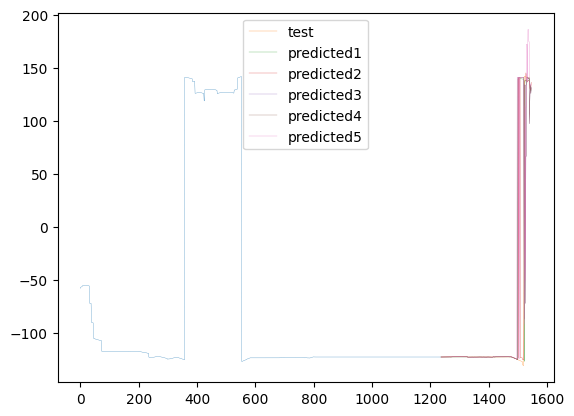

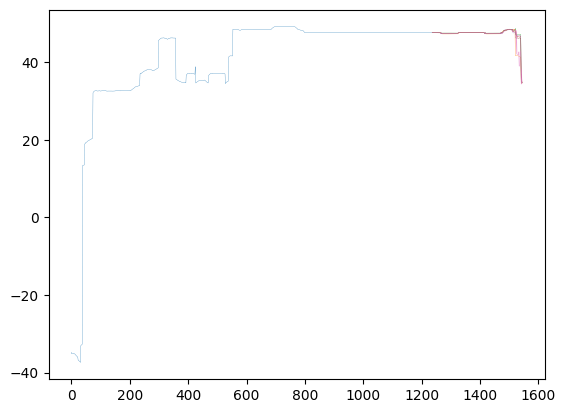

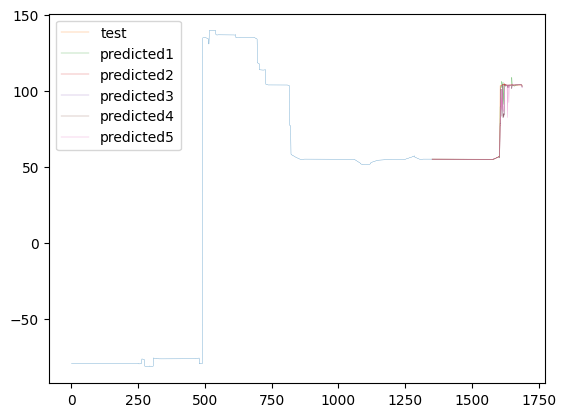

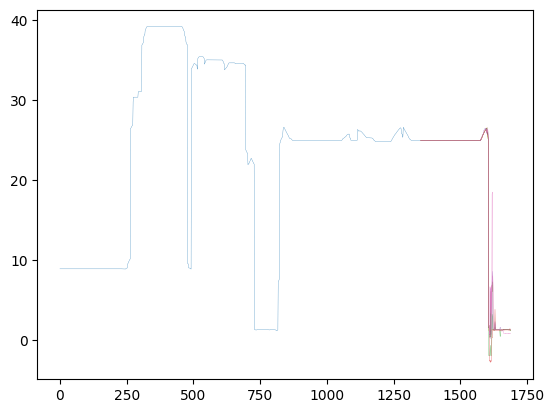

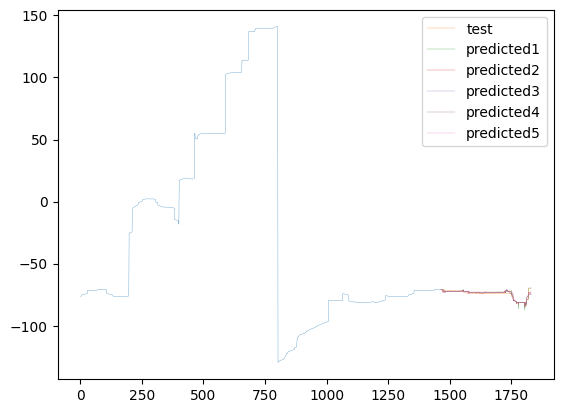

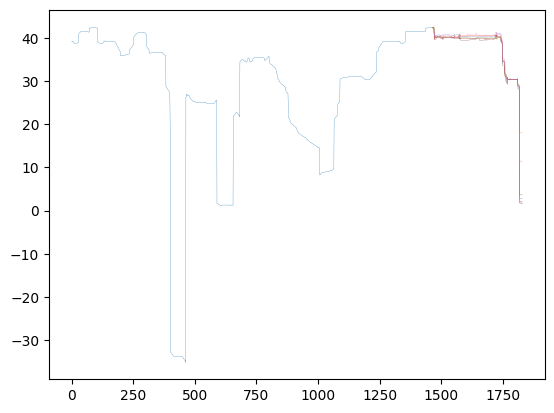

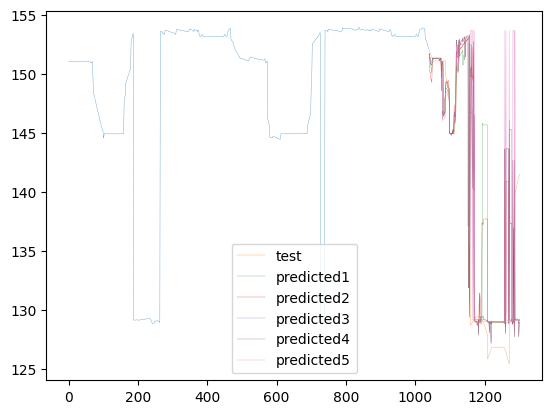

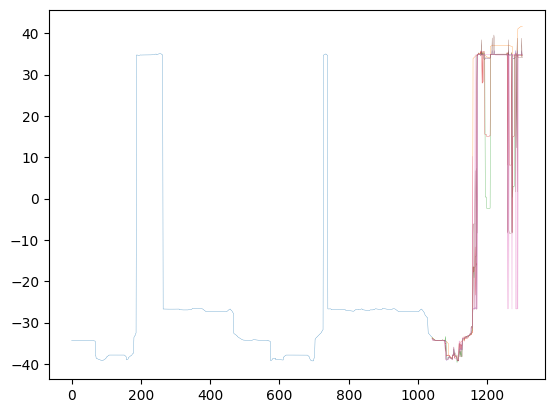

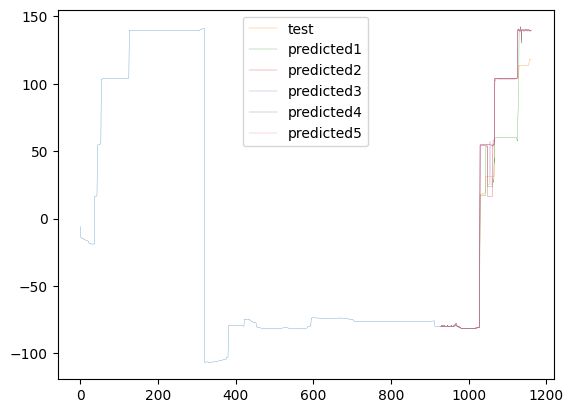

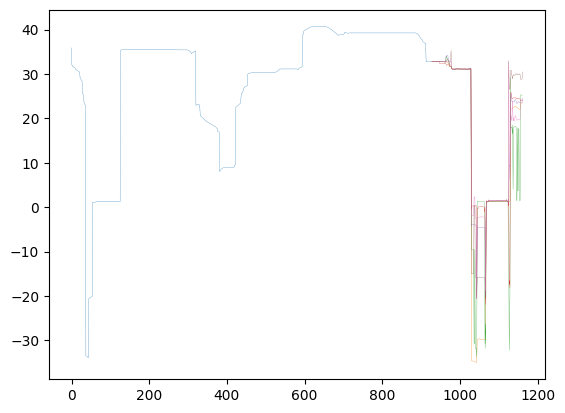

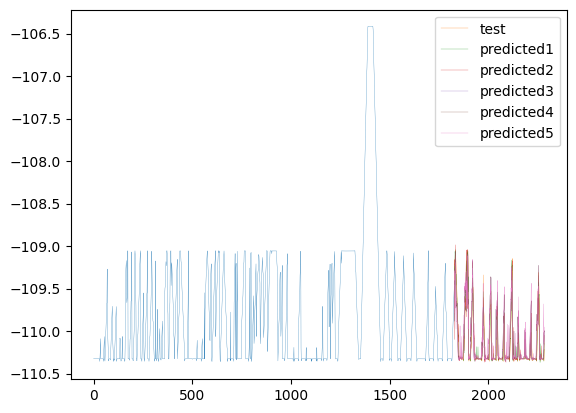

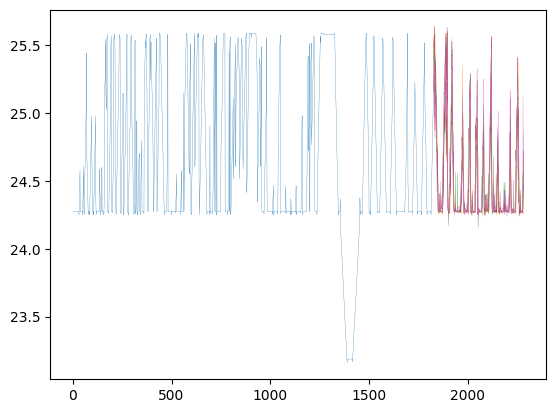

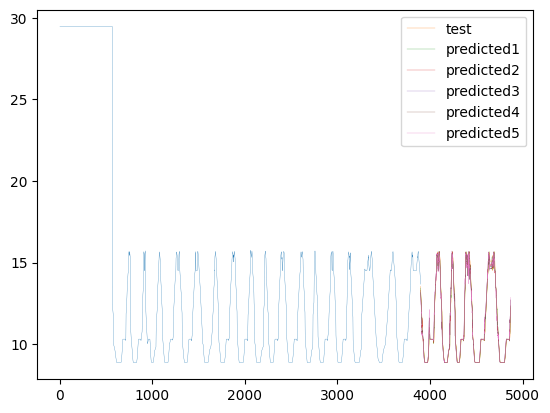

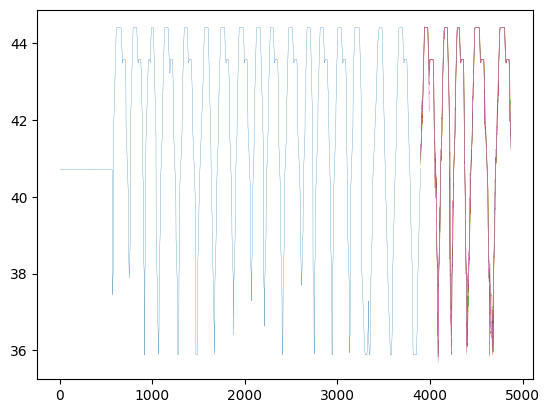

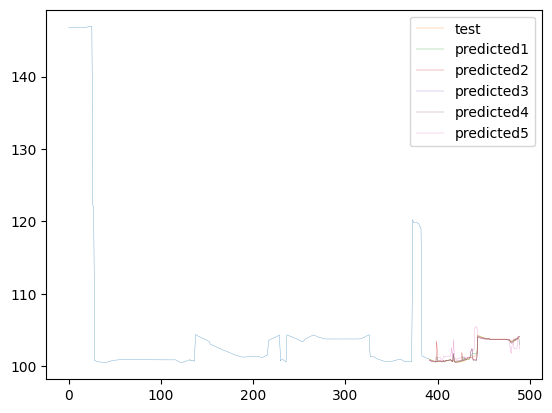

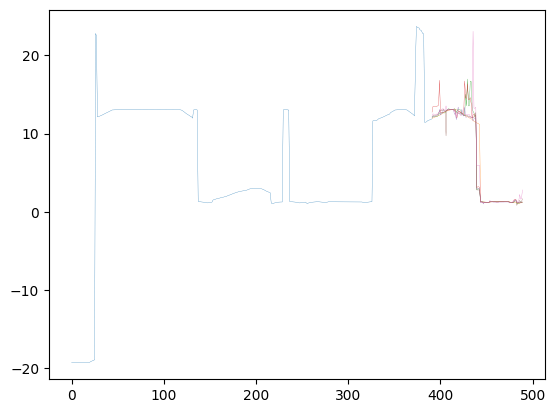

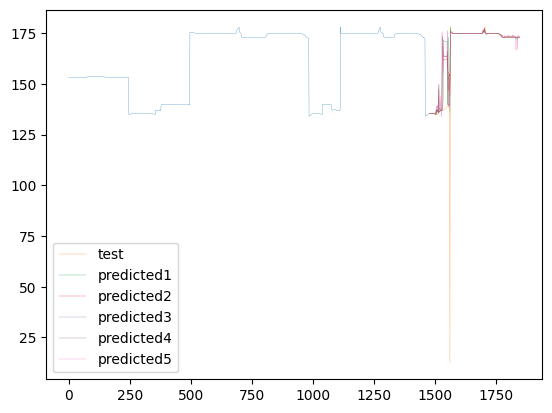

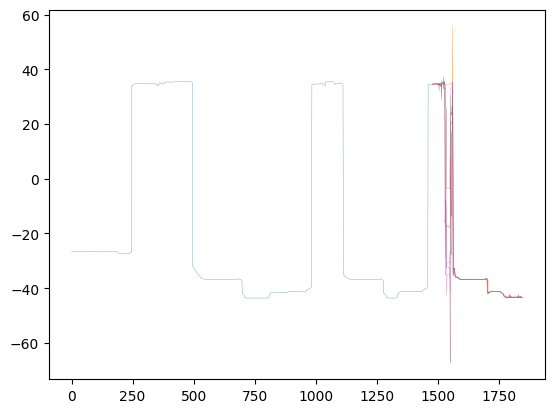

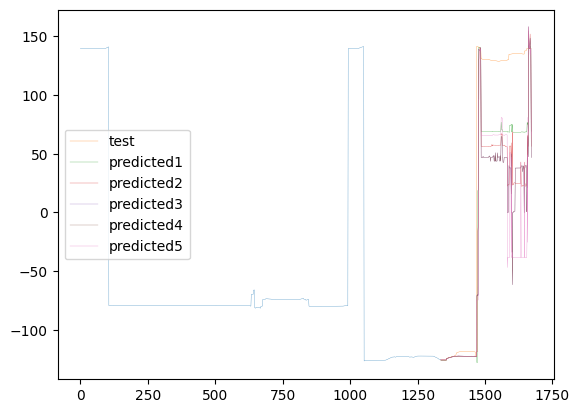

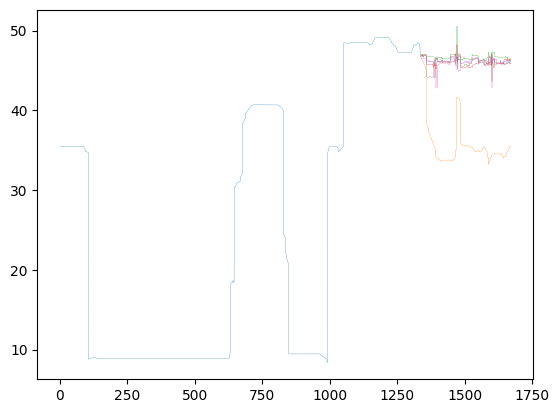

In [16]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

plt.rcParams['lines.linewidth'] = 0.2

for n in range(10):

    features = ['cog','sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'vesselId', 'portId', 'day_of_week', 'hour', 'month']
    targets = ['latitude_1', 'latitude_2', 'latitude_3', 'latitude_4', 'latitude_5', 'longitude_1','longitude_2','longitude_3','longitude_4','longitude_5']

    vessel_df = train_df[train_df['vesselId'] == train_df['vesselId'][n]]

    vessel_df['latitude_1'] = vessel_df['latitude'].shift(-1)
    vessel_df['latitude_2'] = vessel_df['latitude'].shift(-2)
    vessel_df['latitude_3'] = vessel_df['latitude'].shift(-3)
    vessel_df['latitude_4'] = vessel_df['latitude'].shift(-4)
    vessel_df['latitude_5'] = vessel_df['latitude'].shift(-5)


    vessel_df['longitude_1'] = vessel_df['longitude'].shift(-1)
    vessel_df['longitude_2'] = vessel_df['longitude'].shift(-2)
    vessel_df['longitude_3'] = vessel_df['longitude'].shift(-3)
    vessel_df['longitude_4'] = vessel_df['longitude'].shift(-4)
    vessel_df['longitude_5'] = vessel_df['longitude'].shift(-5)

    vessel_df = vessel_df.dropna()


    X_vessel = (vessel_df[features])
    y_vessel = (vessel_df[targets])

    scaler1 = preprocessing.StandardScaler().fit(X_vessel)
    scaler2 = preprocessing.StandardScaler().fit(y_vessel)

    X_vessel = scaler1.transform(X_vessel)
    X_vessel = pd.DataFrame(X_vessel, columns = [features])
    y_vessel = scaler2.transform(y_vessel)
    y_vessel = pd.DataFrame(y_vessel, columns = [targets])


    y_pred = model.predict(X_test)

    timestamps['ordinal'] = timestamps['time'].apply(lambda x: x.toordinal())

    N = int(len(X_vessel)*0.8)

    X_vessel_train = X_vessel[:N]
    y_vessel_train = y_vessel[:N]

    X_vessel_test = X_vessel[N:]
    y_vessel_test = y_vessel[N:]


    model_vessel = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.01, max_depth = 9)
    model_vessel.fit(X_vessel_train, y_vessel_train)

    y_vessel_predict = model_vessel.predict(X_vessel_test)
    y_vessel_predict = scaler2.inverse_transform(y_vessel_predict)

    y_vessel_predict = pd.DataFrame(y_vessel_predict, columns = [targets])
    X_vessel_train = pd.DataFrame(X_vessel_train, columns = [features])
    X_vessel_test = pd.DataFrame(X_vessel_test, columns = [features])

    X_vessel_train = scaler1.inverse_transform(X_vessel_train)
    X_vessel_train = pd.DataFrame(X_vessel_train, columns= [features])
    y_vessel_train = scaler2.inverse_transform(y_vessel_train)
    y_vessel_train = pd.DataFrame(y_vessel_train, columns = [targets])

    X_vessel_test = scaler1.inverse_transform(X_vessel_test)
    X_vessel_test = pd.DataFrame(X_vessel_test, columns = [features])
    y_vessel_test = scaler2.inverse_transform(y_vessel_test)
    y_vessel_test = pd.DataFrame(y_vessel_test, columns = [targets])


    plt.figure()

    plt.plot(np.linspace(0, len(X_vessel_train['longitude']), len(X_vessel_train['longitude'])), X_vessel_train['longitude'])
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), X_vessel_test['longitude'] , label = 'test')
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict['longitude_1'], label = 'predicted1')
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict['longitude_2'], label = 'predicted2')
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict['longitude_4'], label = 'predicted3')
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict['longitude_4'], label = 'predicted4')
    plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict['longitude_5'], label = 'predicted5')
    plt.legend()

    plt.figure()

    plt.plot(np.linspace(0, len(X_vessel_train['latitude']), len(X_vessel_train['latitude'])), X_vessel_train['latitude'])
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), X_vessel_test['latitude'] , label = 'test')
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict['latitude_1'], label = 'predicted1')
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict['latitude_2'], label = 'predicted2')
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict['latitude_3'], label = 'predicted3')
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict['latitude_4'], label = 'predicted4')
    plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict['latitude_5'], label = 'predicted5')


In [18]:

display(y_vessel_predict['longitude_1'])
display(y_vessel_test['longitude_1'])

pred_long = np.array(y_vessel_predict['longitude_1'])
pred_lat = np.array(y_vessel_predict['latitude_1'])

test_long = np.array(y_vessel_test['longitude_1'])
test_lat = np.array(y_vessel_test['latitude_1'])
distances = []

for i in range(np.shape(y_vessel_test)[0]):
    distances.append(geodesic((pred_lat[i], pred_long[i]), (test_lat[i], test_long[i])))

print(np.mean(distances)/1000)

,longitude_1
0,-125.875641
1,-125.881310
2,-125.875641
3,-125.881310
4,-125.881310
...,...
330,141.863068
331,139.732101
332,139.706436
333,139.687210


,longitude_1
0,-125.58245
1,-125.59645
2,-125.61000
3,-125.62453
4,-125.63933
...,...
330,139.73258
331,139.70137
332,139.68628
333,139.68317


3.4654378731692264 km
